# SegGPT

> SegGPT labeling

In [1]:
#| default_exp seg_gpt

- Docs: https://huggingface.co/docs/transformers/main/en/model_doc/seggpt
- Paper: https://arxiv.org/abs/2304.03284.
- Notebook copied from [here](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegGPT/Inference_with_SegGPT_for_one_shot_image_segmentation.ipynb)
- Special thanks to Niels Rogge

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

In [3]:
#| export

from PIL import Image
import requests
import torch
import numpy as np
import cv2

In [4]:
#| export
from cv_tools.core import *

In [5]:
#| export
from transformers import SegGptImageProcessor, SegGptForImageSegmentation


2024-04-28 18:52:35.055762: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 18:52:35.055840: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 18:52:35.055866: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-28 18:52:35.238622: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

In [ ]:
#| hide
# model
checkpoint = "BAAI/seggpt-vit-large"
image_processor = SegGptImageProcessor.from_pretrained(checkpoint)
model = SegGptForImageSegmentation.from_pretrained(
    checkpoint, 
    force_download=True,
    resume_download=False)

# Get the data

In [6]:
image_input_url = "https://raw.githubusercontent.com/baaivision/Painter/main/SegGPT/SegGPT_inference/examples/hmbb_2.jpg"
image_prompt_url = "https://raw.githubusercontent.com/baaivision/Painter/main/SegGPT/SegGPT_inference/examples/hmbb_1.jpg"
mask_prompt_url = "https://raw.githubusercontent.com/baaivision/Painter/main/SegGPT/SegGPT_inference/examples/hmbb_1_target.png"


In [7]:
image_input = Image.open(requests.get(image_input_url, stream=True).raw)
image_prompt = Image.open(requests.get(image_prompt_url, stream=True).raw)
mask_prompt = Image.open(requests.get(mask_prompt_url, stream=True).raw)

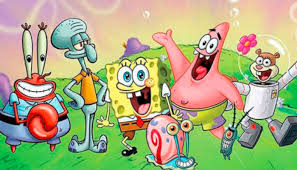

In [8]:
image_input

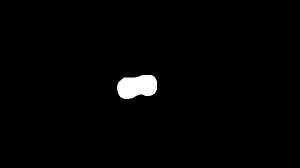

In [9]:
mask_prompt

In [41]:

over_img = overlay_mask_border_on_image_frm_img(
    img=image_prompt, 
    msk=mask_prompt, 
  )

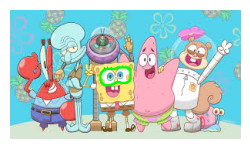

In [42]:
show_(over_img)

## Forward pass

In [10]:
inputs = image_processor(
    images=image_input,
    prompt_images=image_prompt,
    prompt_masks=mask_prompt,
    return_tensors="pt"
)
with torch.no_grad():
    outputs = model(**inputs)
outputs.pred_masks.shape

torch.Size([1, 3, 896, 448])

## Post Process model output

In [11]:
target_sizes = [image_input.size[::-1]]
print(f' target size is = {target_sizes}')
predicted_seg_mask = image_processor.post_process_semantic_segmentation(
    outputs,
    target_sizes=target_sizes,
      )[0]
np_mask = predicted_seg_mask.numpy().astype(np.uint8)

 target size is = [(170, 297)]


In [12]:
outputs.pred_masks.shape

torch.Size([1, 3, 896, 448])

In [13]:
image_input.size, np_mask.shape

((297, 170), (170, 297))

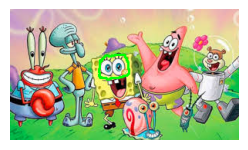

In [61]:
an_img = overlay_mask_border_on_image_frm_img(
    img=image_input, 
    msk=np_mask,
)
show_(an_img)

## Altogether

In [19]:
#| export
def get_mask(
        image_prompt: Image.Image, 
        mask_prompt: Image.Image, 
        test_img: Image.Image,
        model: SegGptForImageSegmentation,
        model_checkpoint: str = "BAAI/seggpt-vit-large",
        show: bool = False, # whehter to show the image with with annotation or not
        save_ann_path: str = None, # save annotated image
        save_msk_path: str = None, # save mask
        ):
    image_processor = SegGptImageProcessor.from_pretrained(model_checkpoint)

    inputs = image_processor(
        images=test_img,
        prompt_images=image_prompt,
        prompt_masks=mask_prompt,
        return_tensors="pt"
    )
    with torch.no_grad():
        outputs = model(**inputs)
    target_sizes = [test_img.size[::-1]]
    predicted_seg_mask = image_processor.post_process_semantic_segmentation(
        outputs,
        target_sizes=target_sizes,
          )[0]
    np_mask = predicted_seg_mask.numpy().astype(np.uint8)
    if show:
        an_img = overlay_mask_border_on_image_frm_img(
            img=test_img, 
            msk=np_mask,
        )
        show_(an_img)
    if save_msk_path:
        cv2.imwrite(save_msk_path, np_mask)
    
    
    return np_mask

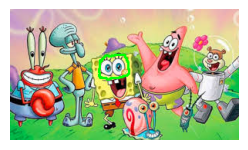

In [21]:
f_msk = get_mask(
    image_prompt=image_prompt, 
    mask_prompt=mask_prompt, 
    test_img=image_input,
    model=model,
    show=True,
    save_msk_path=None,
    )


In [30]:
#| hide
import nbdev; nbdev.nbdev_export()